In [39]:
import pandas as pd
import numpy as np

import config
from psycopg.rows import dict_row
import getdata as gd
import modeling_main as mm

In [40]:
import strategy.trendlabeling as tlb
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt
from afml.sample_weights.attribution import get_weights_by_return
from afml.cross_validation.cross_validation import PurgedKFold
import crossvalidation as cv

In [41]:
import matplotlib.pyplot as plt
import mplfinance as mpl
%matplotlib inline

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

## Import Dataset

In [84]:
#Init
pgConnStr = gd.pgDictToConn(config.pgSecrets)
tickerlst = gd.getFilteredTickerList_Daily(lowest_price=30.0, highest_price=40.0)

In [85]:
random_pick= list(np.random.choice(tickerlst, 10 if len(tickerlst) > 10 else  len(tickerlst), replace=False))
random_pick 

['AQNU', 'FDP', 'GPRE', 'BMEA', 'BROS', 'GLP', 'FSBW', 'CRTO', 'RNST', 'TITN']

In [88]:
ticker = 'GLP'
df = mm.get_data(ticker)
index_SPY = mm.get_index(df, 'SPY')
#index_COMP = mm.get_index(df, 'COMP')

In [89]:
#print(index_COMP['tranx_date'].min(), index_COMP['tranx_date'].max())
print(index_SPY['tranx_date'].min(), index_SPY['tranx_date'].max())
print(df['tranx_date'].min(), df['tranx_date'].max())

2015-12-01 00:00:00-05:00 2023-03-27 00:00:00-04:00
2015-12-01 00:00:00-05:00 2023-03-27 00:00:00-04:00


## Resampling as Dollar Bars

In [90]:
dollar_bars = mm.normalizing(df, dv_multiple=10)
dollar_bars_SPY = bars.transform_index_based_on_dollarbar(dollar_bars, index_SPY)
#dollar_bars_COMP = bars.transform_index_based_on_dollarbar(dollar_bars, index_COMP)

In [91]:
def plot_chart(dollar_bars, name=''):
    plot = mpl.plot(dollar_bars, type='candle', volume=True, figratio=(3,1), style='yahoo', title=name)   
    return plot

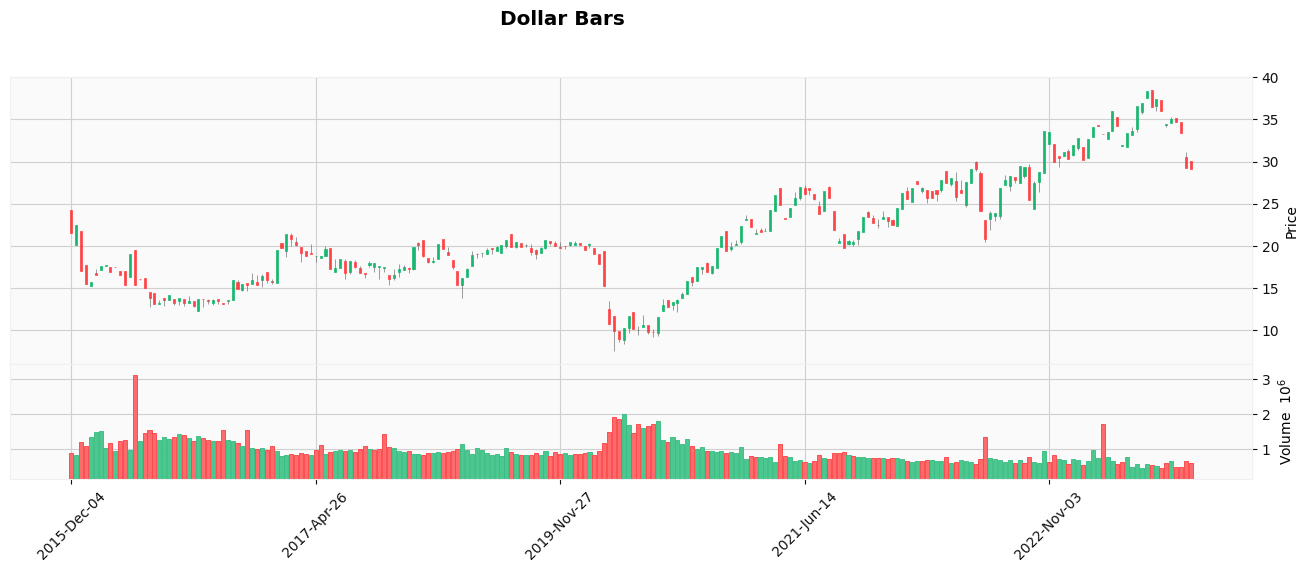

In [92]:
plot_chart(dollar_bars, 'Dollar Bars')

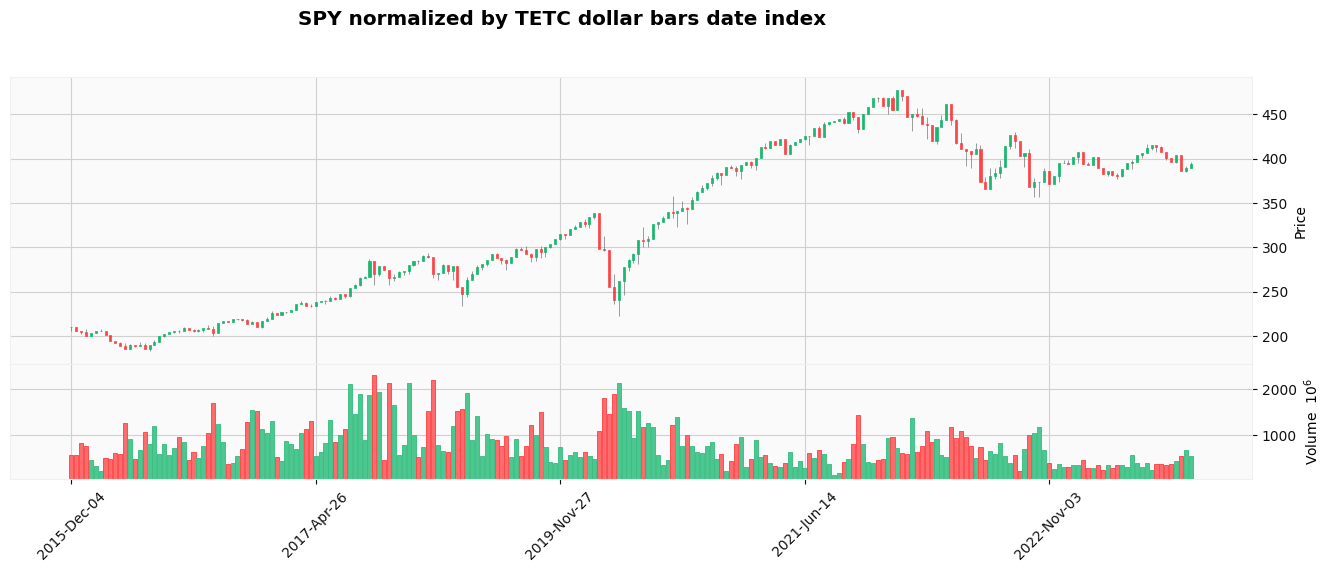

In [93]:
plot_chart(dollar_bars_SPY, 'SPY normalized by TETC dollar bars date index')

In [94]:
#plot_chart(dollar_bars_COMP, 'COMP normalized by TETC dollar bars date index')

## Model 1: Trend Scanning to label as Uptrend or Downtrend

In [95]:
dollar_bars = mm.trend_labeling(dollar_bars, window_size_max=7)

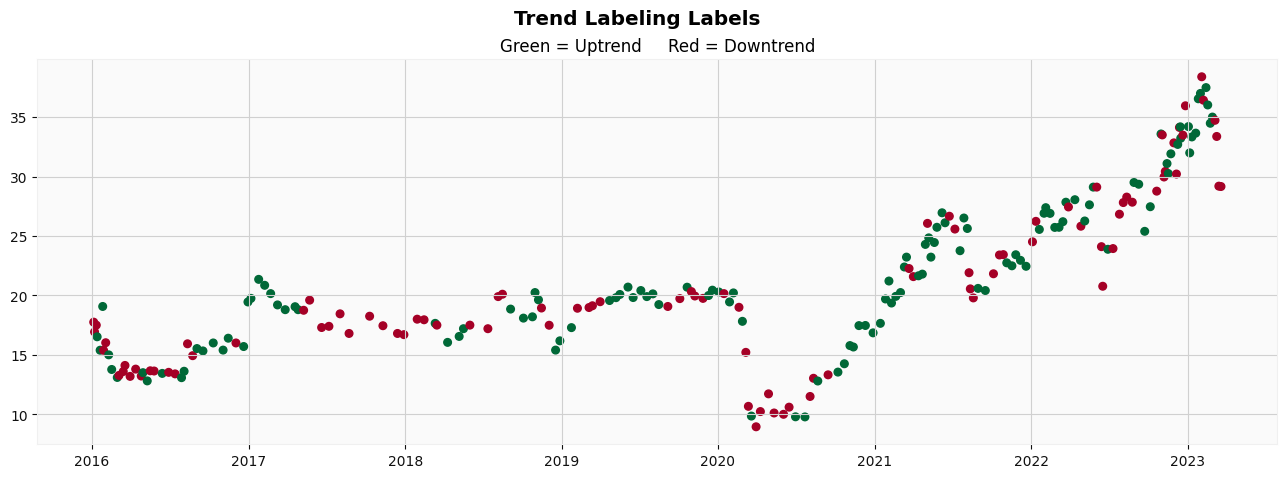

In [96]:
plt.figure(figsize=(16,5))
plt.scatter(dollar_bars.index, dollar_bars['close'], s=30, c=dollar_bars.label, cmap='RdYlGn')
plt.suptitle('Trend Labeling Labels')
plt.title('Green = Uptrend     Red = Downtrend')
plt.show()

In [97]:
# number of uptrends vs # of downtrends
print(dollar_bars['label'].value_counts())

 1.0    126
-1.0     97
Name: label, dtype: int64


## Get Trade Triggering Events based on Volitility Threshold

In [98]:
# Dollar bar close data
close = dollar_bars.close.copy()

# get Daily Volatility as 50 dollar bars exponentially weighted moving std dev
dailyVolatility = vol.getDailyVol(close, span=50)

Text(0.5, 1.0, 'Daily Volatility Estimates \n 50-days Exponentially Weighted Moving Std Dev of Closing Price \n Red Dotted Line = Average')

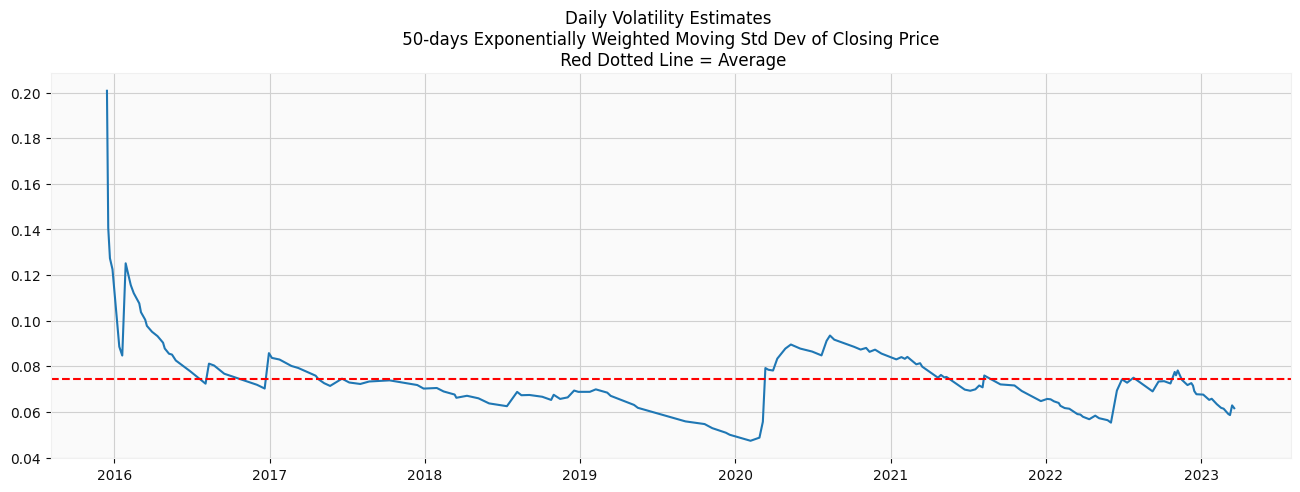

In [99]:
plt.figure(figsize=(16,5))
plt.plot(dailyVolatility)
plt.axhline(dailyVolatility.mean(),ls='--',color='r')
plt.title('Daily Volatility Estimates \n 50-days Exponentially Weighted Moving Std Dev of Closing Price \n Red Dotted Line = Average')

Text(0.5, 1.0, 'Daily Volatility Estimates Distribution \n 50-days Exponentially Weighted Moving Std Dev of Closing Price')

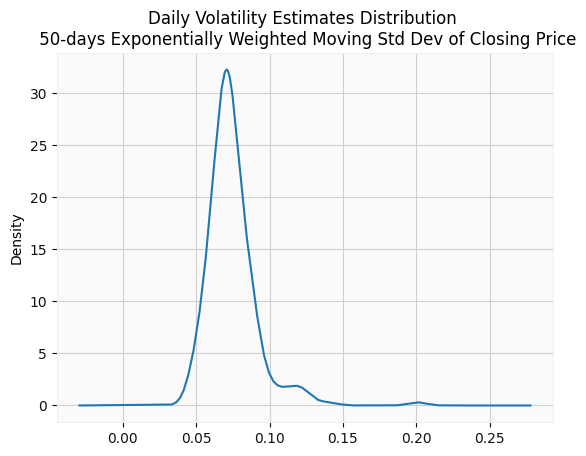

In [100]:
#show distribution of volitility
dailyVolatility.plot.kde()
plt.title('Daily Volatility Estimates Distribution \n 50-days Exponentially Weighted Moving Std Dev of Closing Price')

In [101]:
from scipy.stats import shapiro

# perform Shapiro-Wilk test for normality
stat, p = shapiro(dailyVolatility)

# interpret the results
alpha = 0.05
if p > alpha:
    print('Data is normally distributed (fail to reject H0)')
else:
    print('Data is not normally distributed (reject H0)')


Data is normally distributed (fail to reject H0)


## Create Trade or Not Trade labels using Triple Barrier Method

In [102]:
events, dollar_bars = mm.meta_labeling(dollar_bars,
                               span=50, # Calculate Volatility using 50-days Exp. Rolling Moving Avg
                               filter_multiple=1.0, # identify trade events when accumulated Volatility >= mean of Daily Volatility
                               num_days=10, # Get out of trade if not hit profit in 5 days
                               ptsl=[1,1], # Profit to Loss ratio
                               minRet=0.0 # Identify trade events with at least 0% profit
                               )

In [103]:
# number of uptrends vs # of downtrends
print(dollar_bars['bin'].value_counts())

0.0    56
1.0    17
Name: bin, dtype: int64


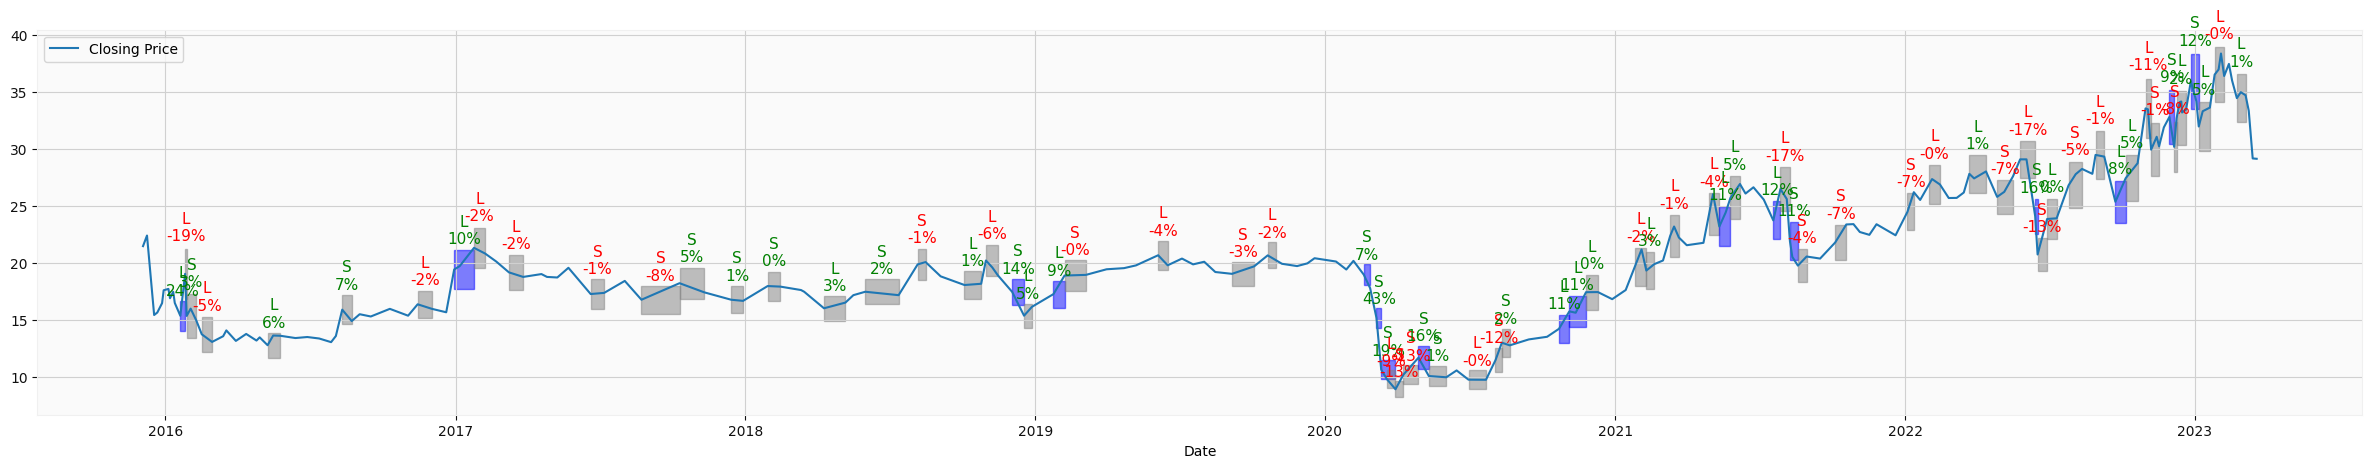

In [104]:
import matplotlib.dates as mdates

plt_temp_df = dollar_bars.copy()
plt_temp_df.set_index(pd.to_datetime(plt_temp_df.index), inplace=True)

fig, ax = plt.subplots(figsize=(30,5))
ax.plot(plt_temp_df.index, plt_temp_df['close'], label='Closing Price')
for i, event in events.iterrows():
    if not pd.isna(event['ret']):
        left = mdates.date2num(i)
        right = mdates.date2num(event['t1'])
        top = event['close'] * (1 + event['trgt'])
        bottom = event['close'] * (1 - event['trgt'])
        width = right - left #(events_df.t1 - events_df.time).dt.days
        height = top - bottom
        if event['bin'] == 1:
            color = 'blue'
        else:
            color = 'grey'
        ax.add_patch(plt.Rectangle((left, bottom), width, height, fill=True, alpha=0.5, color=color))
        
        # add a label indicating whether the event is long or short
        x = left + width / 2
        y = top + height / 10
        if event['label'] == 1:
            label = 'L'
        else:
            label = 'S'

        # add return percentage under the label
        ret_pct = event['ret'] * 100
        if event['ret'] > 0:
            color = 'green'
        elif event['ret'] < 0:
            color = 'red'
        else:
            color = 'black'
        ax.text(x, y, f"{label}\n{ret_pct:.0f}%", ha='center', va='bottom', fontsize=11, color=color)

ax.set_xlabel('Date')
ax.legend()
plt.show()

Data is so imbalance.

## Results of Model 1 without features

Based on the Trend Labeling method, assuming we close out our position within 10 days and we require a 1:1 profit ratio. If we bet on every single uptrend or downtrend signal, our accuracy is only at 26 percent. 

In [105]:
primary_forecast = pd.DataFrame(dollar_bars['bin'].dropna())
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        56
         1.0       0.23      1.00      0.38        17

    accuracy                           0.23        73
   macro avg       0.12      0.50      0.19        73
weighted avg       0.05      0.23      0.09        73

Confusion Matrix
[[ 0 56]
 [ 0 17]]

Accuracy
0.2328767123287671


## Adding more features to the dataset for Model 2

#### Use features: volatility, serial correlation, relative strength to S&P, and original Model 1 slope and trend label

In [106]:
dollar_bars = mm.features_momentum(dollar_bars)
dollar_bars = mm.features_volatility(dollar_bars)
dollar_bars = mm.features_log_returns(dollar_bars)
dollar_bars = mm.features_serial_correlation(dollar_bars)

In [107]:
dollar_bars = mm.features_SPY_RS(dollar_bars, dollar_bars_SPY)

In [108]:
import afml.sampling.concurrent as cur
import afml.sample_weights.attribution as atr
import afml.util.multiprocess as mul
warnings.filterwarnings('ignore')

In [109]:
# compute the number of concurrent events per bar.
cpus =1

numCoEvents = mul.mp_pandas_obj(cur.num_concurrent_events,('molecule', events.index),                         
                              cpus, close_series_index=close.index, label_endtime=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()

# Estimating the Average Uniqueness of a Label
out['tW'] = mul.mp_pandas_obj(cur._get_average_uniqueness,('molecule', events.index),
                            cpus,label_endtime=events['t1'],num_conc_events=numCoEvents)

# Determination of Sample Weight by Absolute Return Attribution

out['w']=mul.mp_pandas_obj(atr._apply_weight_by_return,('molecule', events.index),cpus,
                         label_endtime=events['t1'],num_conc_events=numCoEvents,close_series=close)
out['w']*=out.shape[0]/out['w'].sum()

Text(0.5, 0.98, '# of Cocurrent Events by Timestamp')

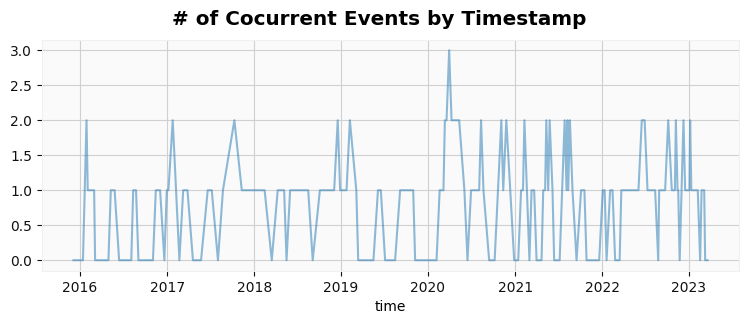

In [110]:
fig, ax = plt.subplots(figsize=(9,3))
numCoEvents.plot(subplots=True, alpha=0.5, ax=ax, x='index')
fig.suptitle('# of Cocurrent Events by Timestamp')

Text(0.5, 0.98, 'Avg Uniqueness of Label (Top) & Sample Weight by Absolute Return Attribution (Bottom)')

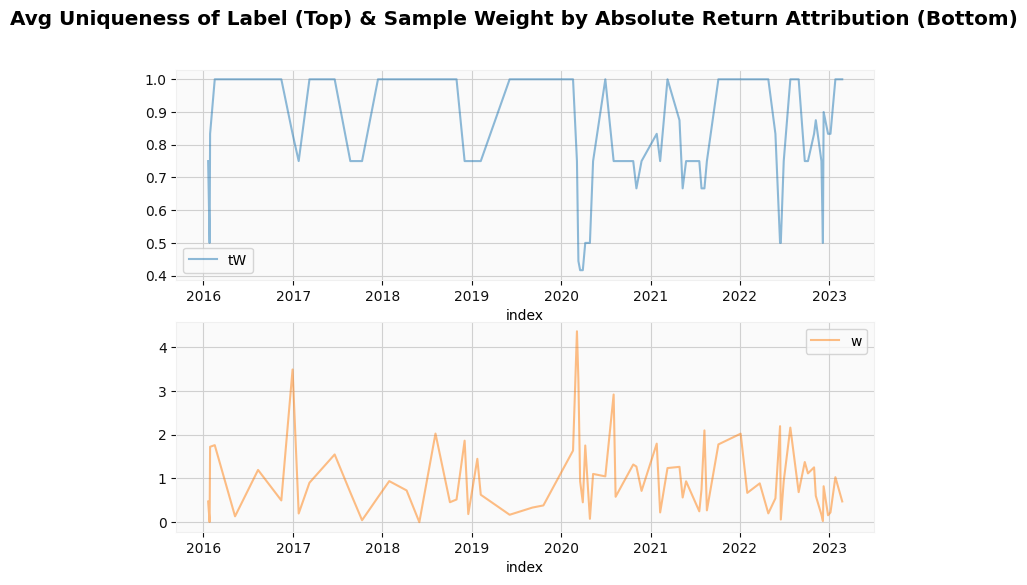

In [111]:
fig, ax = plt.subplots(figsize=(9,6))
out.reset_index().plot(subplots=True, alpha=0.5, ax=ax, x='index')
fig.suptitle('Avg Uniqueness of Label (Top) & Sample Weight by Absolute Return Attribution (Bottom)')

In [112]:
coEvents_std = (
    pd.DataFrame()
    .assign(
        numCoEvents = numCoEvents,
        std = mkt.returns(dollar_bars.close).ewm(50).std())
)

Text(0.5, 0.98, 'Label Concurrency vs Returns Volitility')

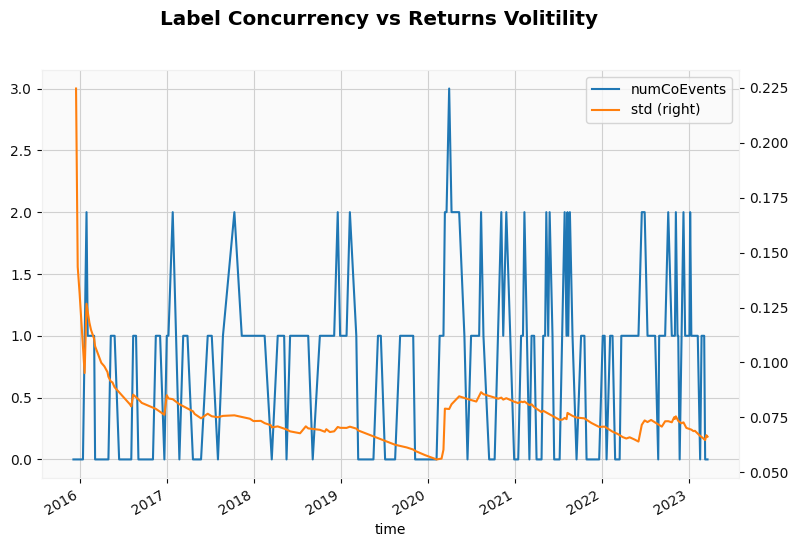

In [113]:
fig, ax = plt.subplots(figsize=(9,6))

coEvents_std.numCoEvents.plot(legend=True, ax=ax, x='index')
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax, x='index')
fig.suptitle('Label Concurrency vs Returns Volitility')

## Model 2 - Model Fitting

#### Due to Label Concurrency, we will apply custom sample weights to the training

In [114]:
clfs = ['random_forest', 
        'standard_bagging_decision_tree', 
        'sequential_bootstrapping_decision_tree',
        'SVC',
        'sequential_bootstrapping_SVC'
        ]

best_cv_clfs = {}
model_metrics_df = pd.DataFrame()

for c in clfs:
    this_clf, model_metrics = mm.modeling(ticker, events, dollar_bars, type=c, RANDOM_STATE = 42)
    best_cv_clfs[c]=this_clf
    model_metrics_df = pd.concat([model_metrics_df, model_metrics], ignore_index=True)

In [146]:
import plotly.graph_objects as go

model_metrics_tbl = model_metrics_df.drop(['symbol', 'best_model', 'performed_on'], axis=1)

fig = go.Figure(data=[go.Table(
    columnwidth = [280,150,80,80,80,80,100],
    header=dict(values=list(model_metrics_tbl.columns),
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=model_metrics_tbl.transpose().values.tolist(),
               fill_color='lavender',
               align='center',
               format=['', '.4f', '.4f','.4f','.4f','.4f','','','']
               )),
])              

fig.show()

In [117]:
# train test split
col = ['open', 'high', 'low', 'close', 'volume', 'bin']
dollar_bars = dollar_bars.dropna()
X = dollar_bars.drop(col, axis=1)
y = dollar_bars['bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# sample weights
return_based_sample_weights_test = get_weights_by_return(events.loc[X_test.index], dollar_bars.loc[X_test.index, 'close'])

In [118]:
from sklearn.preprocessing import StandardScaler
col = X_test.columns.to_list()
idx = X_test.index
X_test_scaled = StandardScaler().fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col, index=idx)

              precision    recall  f1-score   support

         0.0       0.77      0.78      0.78 9.887277729003758
         1.0       0.27      0.25      0.26 3.112722270996244

    accuracy                           0.66 13.000000000000002
   macro avg       0.52      0.52      0.52 13.000000000000002
weighted avg       0.65      0.66      0.65 13.000000000000002



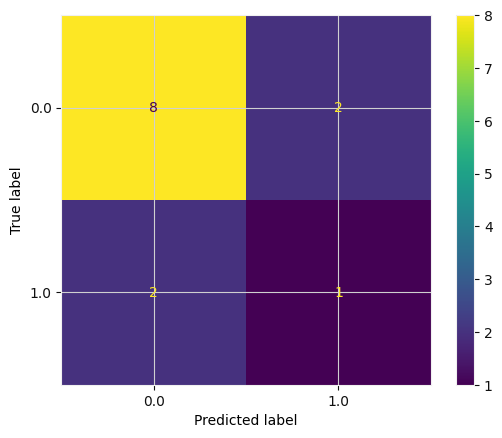

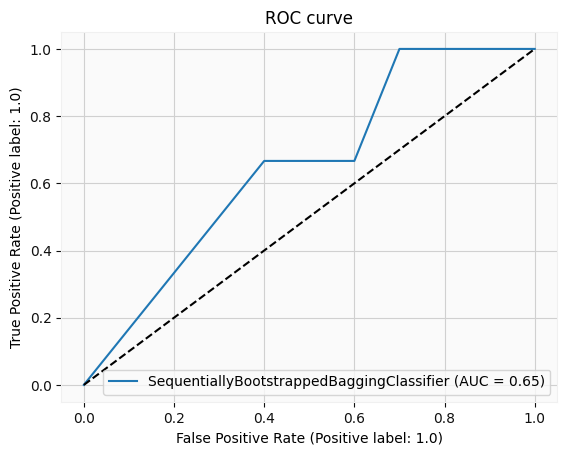

In [145]:
try_clf = 'sequential_bootstrapping_SVC'

y_pred = best_cv_clfs[try_clf].predict(X_test_scaled)

print(classification_report(y_test, y_pred, sample_weight=return_based_sample_weights_test))

ConfusionMatrixDisplay.from_estimator(best_cv_clfs[try_clf], X_test_scaled, y_test)
plt.show()

SVC_ROC = RocCurveDisplay.from_estimator(best_cv_clfs[try_clf], X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

We will use the Sequential Bootstrapped SVC classfier as the base model outperforms tree-based classifiers. Sequential Bootstrapping helps avoid overfitting by lowering down the probability of resampling repeated data during the bagging process.

## Feature Importance

The SVC classifier does not provide a direct wat to obtain feature importances. However, we can use the coefficients of the hyperplane that seperates the classes to estimate the importance of each feature. The magnitude of the coefficient corresponds to the importance of the corresponding feature in the classification.

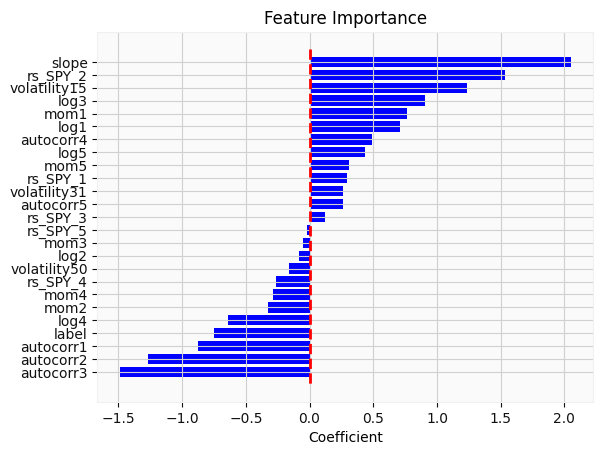

In [122]:
# todo

# Get coefficients of hyperplane
coef = best_cv_clfs['SVC'].coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()


## Backtesting Results

In [134]:
# prep the dataframe
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}, index=X_test.index)
X_test_with_results = pd.concat([X_test, results_df], axis=1)
merged_df = pd.merge(X_test_with_results, events, left_index=True, right_index=True)

In [135]:
# trade returns of predicted trades 
transaction_cost = 0.00
slippage = 0.000

merged_df['y_pred_trade_ret'] = 0
merged_df.loc[merged_df['y_pred'] == 1, 'y_pred_trade_ret'] = merged_df.loc[merged_df['y_pred'] == 1, 'ret'] - (transaction_cost + slippage)
merged_df_sorted = merged_df.sort_values('t1')


In [136]:
# cumulative returns
merged_df_sorted['cumulative_returns'] = (merged_df_sorted['y_pred_trade_ret'] + 1).cumprod() - 1
cum_rtn_plot = merged_df_sorted.groupby('t1')['cumulative_returns', 'y_pred_trade_ret'].last()
cum_rtn_plot = pd.DataFrame(cum_rtn_plot)

### Cumulative Returns

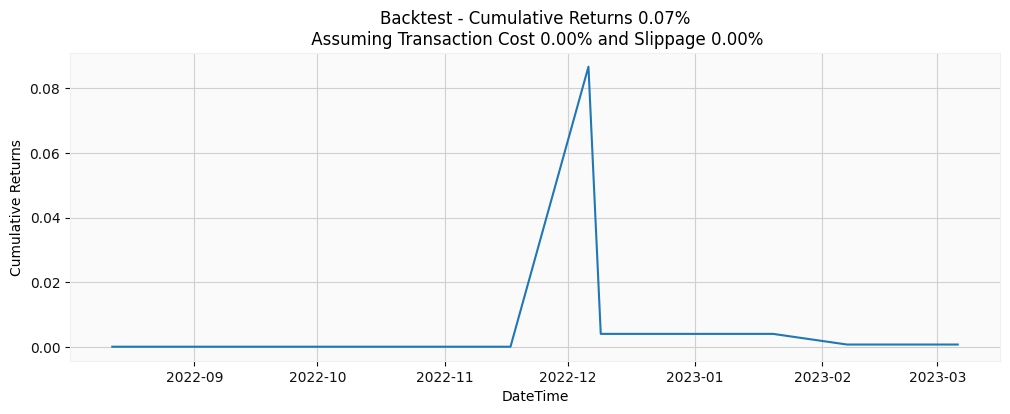

In [141]:
# Visualize the results
plt.figure(figsize=(12, 4))
plt.plot(cum_rtn_plot.index, cum_rtn_plot.cumulative_returns)

plt.xlabel('DateTime')
plt.ylabel('Cumulative Returns')
plt.hlines(y=0, xmin=None, xmax=None, colors='r', linestyles='--')
plt.title('Backtest - Cumulative Returns {}\n Assuming Transaction Cost {} and Slippage {}'\
          .format(str(round(cum_rtn_plot.iloc[-1].cumulative_returns*100,2))+'%', "{:.2%}".format(transaction_cost), "{:.2%}".format(slippage)))
plt.show()

#### Sharpe Ratio

In [138]:
# https://ycharts.com/indicators/3_year_treasury_rate Long Term Average Rist Free Rate as at Mar 24, 2023
daily_risk_free_rate = 0.036 / 252  # https://ycharts.com/indicators/3_year_treasury_rate Long Term Average Rist Free Rate as at Mar 24, 2023

# calculate daily returns for each trading day
trading_days = pd.DataFrame(pd.bdate_range(start=merged_df.index.min(), end=cum_rtn_plot.index.max(), freq='B'), columns=['trading_days'])
trading_days.index =trading_days['trading_days']
sharpe_df = pd.merge(trading_days, cum_rtn_plot['cumulative_returns'], left_index=True, right_index=True, how='left').fillna(method='ffill')
sharpe_df['cumulative_returns'] = sharpe_df['cumulative_returns'].fillna(0)
sharpe_df['daily_returns'] = sharpe_df['cumulative_returns'].diff().fillna(0)
sharpe_df['day'] = 1
sharpe_df['trading_days'] = sharpe_df['day'].cumsum()
sharpe_df['rolling_std_dev'] =sharpe_df['daily_returns'].expanding().std(ddof=0)
sharpe_df['cumulative_sharpe'] = ((sharpe_df['cumulative_returns']/sharpe_df['trading_days'])-daily_risk_free_rate) / sharpe_df['rolling_std_dev'] * np.sqrt(252)
sharpe_df = sharpe_df.fillna(0)


In [139]:
# Calculate the average daily return and standard deviation of daily returns
avg_daily_return = np.mean(sharpe_df.daily_returns)
std_daily_return = np.std(sharpe_df.daily_returns)

# Calculate the Sharpe ratio
daily_risk_free_rate = 0.036 / 252  
sharpe_ratio = round((avg_daily_return - daily_risk_free_rate) / std_daily_return * np.sqrt(252), 2)

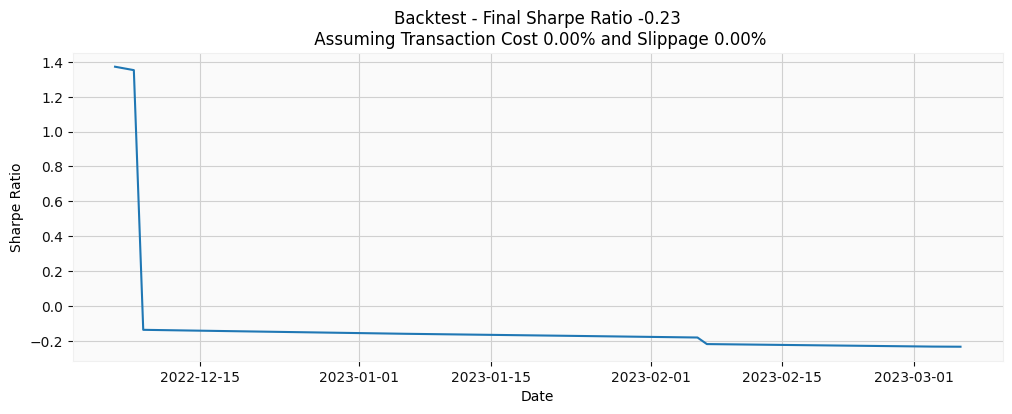

In [142]:
plt.figure(figsize=(12, 4))
plt.plot(sharpe_df.index, sharpe_df['cumulative_sharpe'])
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('Backtest - Final Sharpe Ratio {}\n Assuming Transaction Cost {} and Slippage {}'\
          .format(sharpe_ratio, "{:.2%}".format(transaction_cost), "{:.2%}".format(slippage)))
plt.show()